In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import scipy.stats as stats
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector

from lifelines import CoxPHFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import pairwise_logrank_test
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts
import glob, os

stats = importr('stats')

import warnings
warnings.filterwarnings("ignore")

## Preparing data for survival analysis

In [2]:
## Customizing plot
commonFontsize=8
def config_rcparams():
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['font.sans-serif'] = ['arial']
    plt.rcParams['font.size'] = commonFontsize
    plt.rcParams['axes.labelsize'] = commonFontsize
    plt.rcParams['xtick.labelsize'] = commonFontsize
    plt.rcParams['ytick.labelsize'] = commonFontsize
    plt.rcParams['axes.titlesize'] = commonFontsize
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.cal'] = 'arial'
    plt.rcParams['mathtext.rm'] = 'arial'
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['axes.linewidth'] = 0.7
    plt.rcParams['xtick.major.width'] = 0.7
    plt.rcParams['ytick.major.width'] = 0.7
    plt.rcParams['xtick.major.size' ] = 3
    plt.rcParams['ytick.major.size' ] = 3
config_rcparams()

## 2. Coxproportional hazard ratio calculation

In [3]:
## file path to data folder. listing tcga tumor tissue name
os.chdir("data/tcga_tumor/")
tumor_tissue=[]
for  i in glob.glob("*.tsv"):
    tumor_tissue.append(i)
tumor_tissue=[e for e in tumor_tissue if e not in ('THYM.tsv','TGCT.tsv','PCPG.tsv','DLBC.tsv','THCA.tsv','KICH.tsv' )]

In [4]:
## Computing the hazard ratio for IP with its different confounders
######## tumor purity information####################################################################
tumor_purity_df=pd.read_csv("data/TCGA_mastercalls.abs_tables_JSedit.fixed.txt",sep='\t')
tumor_purity_df['sample_id']=tumor_purity_df['array'].str.split('-').str[0:3].str.join('.')
tumor_purity_df=tumor_purity_df[['purity','sample_id']]
tumor_purity_df=tumor_purity_df.set_index('sample_id')
#### Mutational file ##############################################################################
tumor_mutation_df = pd.read_csv('data/tcga_cohort.txt', sep="\t",header = 0)
tumor_mutation_df['TMB']=tumor_mutation_df['total']/35.8
tumor_mutation_df['Tumor_Sample_Barcode']=tumor_mutation_df['Tumor_Sample_Barcode'].str.split('-').str[0:3].str.join('.')
tumor_mutation_df=tumor_mutation_df.set_index('Tumor_Sample_Barcode')
######### stage age gender included into the list of variables####################################
xls_1 = pd.ExcelFile('data/mmc1.xlsx')
df_1 = xls_1.parse(0)
df_age_sex_grade_info=df_1[['bcr_patient_barcode','type','age_at_initial_pathologic_diagnosis','gender','ajcc_pathologic_tumor_stage','OS','OS.time']]
df_age_sex_grade_info['bcr_patient_barcode']=df_age_sex_grade_info['bcr_patient_barcode'].str.split('-').str[0:3].str.join('.')
df_age_sex_grade_info=df_age_sex_grade_info.set_index('bcr_patient_barcode')
df_age_sex_grade_info['gender']=df_age_sex_grade_info['gender'].replace(['MALE','FEMALE'],[1,2])
df_age_sex_grade_info['ajcc_pathologic_tumor_stage'] = df_age_sex_grade_info['ajcc_pathologic_tumor_stage'].replace(['Stage IA','Stage IB','Stage IIA','Stage IIB','Stage IIC','Stage IIIA','Stage IIIB','Stage IIIC','Stage IVA','Stage IVB','Stage IVC'],['Stage I','Stage I','Stage II','Stage II','Stage II','Stage III','Stage III','Stage III','Stage IV','Stage IV','Stage IV'])
df_age_sex_grade_info['ajcc_pathologic_tumor_stage'] = df_age_sex_grade_info['ajcc_pathologic_tumor_stage'].replace(['Stage I','Stage II','Stage III','Stage IV'],[1,2,3,4])
##################################################################################################

input_path1="data/tcga_tumor/"
input_path3="data/r_output/"
hazard_ratio_frame={}
variables=['immuno_proteosome','Regulatory T cell','Cytotoxic cells','Exhaustive T cell','TMB','purity','const_proteosome','age_at_initial_pathologic_diagnosis','gender','ajcc_pathologic_tumor_stage']
feature_set=[]
for j in range(0,11):
    if j==0:
        feature_set=[variables[0],'OS','OS.time']
        cytotoxic_hazard_summary=[]
        tumor_tissue1=[]
    elif j==10:
        variables1=variables
        variables1.extend(['OS','OS.time'])
        feature_set=variables1
        cytotoxic_hazard_summary=[]
        tumor_tissue1=[]
    else :
        feature_set=[variables[0],variables[j],'OS','OS.time']
        cytotoxic_hazard_summary=[]
        tumor_tissue1=[]
    for i in range(len(tumor_tissue)):
        gene_data_frame=pd.read_csv(input_path1+tumor_tissue[i],sep='\t',index_col=0)
        gene_data_frame.columns=gene_data_frame.columns.str.split('-').str[0:3].str.join('.')
        gene_data_frame=gene_data_frame.T+1

        log_gene_data_frame=np.log2(gene_data_frame)
        log_gene_data_frame['const_proteosome']=(1/3)*(log_gene_data_frame['PSMB5']+log_gene_data_frame['PSMB6']+log_gene_data_frame['PSMB7'])
        log_gene_data_frame['immuno_proteosome']=(1/3)*(log_gene_data_frame['PSMB8']+log_gene_data_frame['PSMB9']+log_gene_data_frame['PSMB10'])

        immune_gsva_score=pd.read_csv(input_path3+'GSVA_'+'immune_cells_'+tumor_tissue[i],sep='\t')

        df3=pd.merge(log_gene_data_frame[['const_proteosome','immuno_proteosome']],immune_gsva_score.T,left_index=True, right_index=True) ## Proteasome+Immune cells
        df_immunogenicity_proteasome_immune_cells_score1=pd.merge(df3,tumor_purity_df,left_index=True, right_index=True)  ## Proteasome+Immune cells+ purity
        df_immunogenicity_proteasome_immune_cells_score2=pd.merge(df_age_sex_grade_info,df_immunogenicity_proteasome_immune_cells_score1,left_index=True, right_index=True) #Proteasome+Immune cells+ purity+age_sex_grade
        df_immunogenicity_proteasome_immune_cells_score3=pd.merge(tumor_mutation_df,df_immunogenicity_proteasome_immune_cells_score2,left_index=True, right_index=True)  # #Proteasome+Immune cells+ purity+age_sex_grade +TMB
        df_subset=df_immunogenicity_proteasome_immune_cells_score3[feature_set]
        #-------------------------------------------------------------------------------------------------------------------
        if 'ajcc_pathologic_tumor_stage' in (list(df_subset.columns)):
            df_subset=df_subset.drop(df_subset[df_subset.ajcc_pathologic_tumor_stage=='[Not Available]'].index)
            df_subset=df_subset.drop(df_subset[df_subset.ajcc_pathologic_tumor_stage=='[Not Applicable]'].index)
            df_subset=df_subset.drop(df_subset[df_subset.ajcc_pathologic_tumor_stage=='[Discrepancy]'].index)
            df_subset=df_subset.drop(df_subset[df_subset.ajcc_pathologic_tumor_stage=='[Unknown]'].index)
            df_subset=df_subset.drop(df_subset[df_subset.ajcc_pathologic_tumor_stage=='I/II NOS'].index)
            df_subset=df_subset.drop(df_subset[df_subset.ajcc_pathologic_tumor_stage=='Stage X'].index)
            df_subset=df_subset.dropna()
        else:
            df_subset=df_subset.dropna()
    

        try:
            cph = CoxPHFitter()
            cph.fit(df_subset, duration_col='OS.time', event_col='OS')
            cytotoxic_hazard_summary.append(list(cph.summary.iloc[0]))
            tumor_tissue1.append(tumor_tissue[i].split('.')[0])
        except:
            pass 

    df_tmp_immuno=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
    df_tmp_immuno.index=tumor_tissue1
    df_tmp_immuno['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno['p'])), method = 'BH')
    df_tmp_immuno['error_bar']=np.abs(((df_tmp_immuno['coef upper 95%'])-(df_tmp_immuno['coef lower 95%']))/2)
    hazard_ratio_frame[j]=df_tmp_immuno

In [5]:
hr_df_ip=pd.DataFrame()
for i in range(11):
    hr_df_ip=pd.concat([hr_df_ip,hazard_ratio_frame[i][['coef','p_adjust']]],axis=1)

col_list=['IP[log(HR)]',
 'IP[P_adjust]',
 'IP+T_reg[log(HR)]',
 'IP+T_reg[P_adjust]',
 'IP+Cytoxtoxic score[log(HR)]',
 'IP+Cytoxtoxic score[P_adjust]',
 'IP+Exhausted T cell[log(HR)]',
 'IP+Exhausted T cell[P_adjust]',
 'IP+TMB[log(HR)]',
 'IP+TMB[P_adjust]',
 'IP+purity[log(HR)]',
 'IP+purity[P_adjust]',
 'IP+CP[log(HR)]',
 'IP+CP[P_adjust]',
 'IP+age[log(HR)]',
 'IP+age[P_adjust]',
 'IP+gender[log(HR)]',
 'IP+gender[P_adjust]',
 'IP+stage[log(HR)]',
 'IP+stage[P_adjust]',
 'IP+all[log(HR)]',
 'IP+all[P_adjust]']
hr_df_ip.columns=col_list

In [6]:
hr_df_ip[(hr_df_ip['IP[P_adjust]']<0.1)|(hr_df_ip['IP+T_reg[P_adjust]']<0.1)|(hr_df_ip['IP+Cytoxtoxic score[P_adjust]']<0.1)|(hr_df_ip['IP+Exhausted T cell[P_adjust]']<0.1)]#|[(hazard_ratio_df['IP+T_reg[P_adjust]']<0.1]))

,IP[log(HR)],IP[P_adjust],IP+T_reg[log(HR)],IP+T_reg[P_adjust],IP+Cytoxtoxic score[log(HR)],IP+Cytoxtoxic score[P_adjust],IP+Exhausted T cell[log(HR)],IP+Exhausted T cell[P_adjust],IP+TMB[log(HR)],IP+TMB[P_adjust],...,IP+CP[log(HR)],IP+CP[P_adjust],IP+age[log(HR)],IP+age[P_adjust],IP+gender[log(HR)],IP+gender[P_adjust],IP+stage[log(HR)],IP+stage[P_adjust],IP+all[log(HR)],IP+all[P_adjust]
MESO,-0.428580,0.022594,-0.460649,0.009611,-0.276175,0.390514,-0.467056,0.056940,-0.431654,0.022090,...,-0.597087,3.207793e-03,-0.401973,0.053724,-0.454841,0.015715,-0.432319,0.031990,-0.801626,0.051832
CESC,-0.260876,0.045738,-0.299973,0.023283,-0.180016,0.410983,-0.052589,0.842656,-0.262048,0.055487,...,-0.250900,8.281303e-02,-0.258918,0.058967,NaN,NaN,NaN,NaN,NaN,NaN
UVM,0.544349,0.002787,0.689207,0.002181,0.459469,0.120881,0.228181,0.675648,0.538482,0.003176,...,0.497814,6.746475e-03,0.558953,0.002720,0.554728,0.002203,0.513725,0.008346,-0.004556,0.993286
SARC,-0.270333,0.035320,-0.417765,0.009000,-0.100179,0.691476,-0.361130,0.043382,-0.260911,0.050508,...,-0.387436,2.991718e-03,-0.344816,0.014838,-0.270490,0.029688,NaN,NaN,NaN,NaN
BLCA,-0.156086,0.035320,-0.343369,0.000134,-0.021090,0.942189,-0.182447,0.175664,-0.144807,0.060875,...,-0.212897,5.234894e-03,-0.123131,0.119566,-0.166719,0.021453,-0.134775,0.125559,-0.245776,0.253296
LGG,0.577954,0.000005,0.529521,0.000229,0.685848,0.000003,0.540311,0.001347,0.575132,0.000006,...,0.748273,1.617994e-08,0.457343,0.000601,0.580871,0.000004,NaN,NaN,NaN,NaN
LAML,0.865519,0.010545,1.062985,0.002077,0.736340,0.069592,0.744782,0.055450,0.797209,0.019238,...,0.824828,3.228906e-02,0.573361,0.094621,0.877175,0.004920,NaN,NaN,NaN,NaN
SKCM,-0.309880,0.000006,-0.269576,0.000664,-0.273763,0.008290,-0.067762,0.675648,-0.311503,0.000006,...,-0.315360,2.429665e-06,-0.291046,0.000065,-0.305408,0.000009,-0.323938,0.000016,-0.021845,0.993286
BRCA,-0.238237,0.022594,-0.321517,0.002077,-0.147252,0.416910,-0.360827,0.040087,-0.252561,0.016980,...,-0.253082,2.074464e-02,-0.207435,0.053724,-0.238420,0.017113,-0.200425,0.125559,-0.259014,0.369222
KIRC,0.385658,0.018560,0.382291,0.011520,0.628923,0.004717,0.432929,0.073341,0.392887,0.016980,...,0.203210,4.011892e-01,0.330353,0.053724,0.399903,0.010820,0.099581,0.782621,0.114441,0.955535


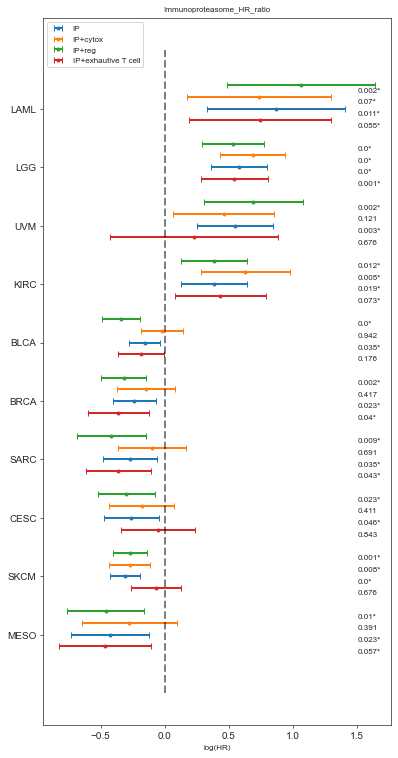

In [7]:
### plotting significant hazard ratio in different tumor tissues
tt_list=['MESO','SKCM','CESC','SARC','BRCA','BLCA','KIRC','UVM','LGG','LAML']

df_tmp_immuno=hazard_ratio_frame[0]
df_tmp_immuno=df_tmp_immuno.sort_values(by=['coef'])
df_tmp_immuno=df_tmp_immuno.loc[tt_list]
df_tmp_immuno['y_value']=np.array(range(1,11))

df_tmp_immuno_cytox=hazard_ratio_frame[2]
df_tmp_immuno_cytox=df_tmp_immuno_cytox.reindex(df_tmp_immuno.index)
df_tmp_immuno_cytox=df_tmp_immuno_cytox.loc[tt_list]
df_tmp_immuno_cytox['y_value']=np.array(range(1,11))

df_tmp_immuno_reg=hazard_ratio_frame[1]
df_tmp_immuno_reg=df_tmp_immuno_reg.reindex(df_tmp_immuno.index)
df_tmp_immuno_reg=df_tmp_immuno_reg.loc[tt_list]
df_tmp_immuno_reg['y_value']=np.array(range(1,11))

df_tmp_immuno_Exhausted_T_cell_score=hazard_ratio_frame[3]
df_tmp_immuno_Exhausted_T_cell_score=df_tmp_immuno_Exhausted_T_cell_score.reindex(df_tmp_immuno.index)
df_tmp_immuno_Exhausted_T_cell_score=df_tmp_immuno_Exhausted_T_cell_score.loc[tt_list]
df_tmp_immuno_Exhausted_T_cell_score['y_value']=np.array(range(1,11))


x = np.array(df_tmp_immuno['coef'])
y = np.array(df_tmp_immuno['y_value'])
err=np.array(df_tmp_immuno['error_bar'])
y_ticks_labels = list(df_tmp_immuno.index)
l1 = np.arange(1,11,1)

x_1 = np.array(df_tmp_immuno_cytox['coef'])
y_1 = np.array(df_tmp_immuno_cytox['y_value'])
y_1=y_1+0.20
err_1=np.array(df_tmp_immuno_cytox['error_bar'])
y_ticks_labels_1 = list(df_tmp_immuno_cytox.index)
l1_1 = np.arange(1,11,1)

x_2 = np.array(df_tmp_immuno_reg['coef'])
y_2 = np.array(df_tmp_immuno_reg['y_value'])
y_2=y_2+0.40
err_2=np.array(df_tmp_immuno_reg['error_bar'])
y_ticks_labels_2 = list(df_tmp_immuno_reg.index)
l1_2 = np.arange(1,11,1)

x_3 = np.array(df_tmp_immuno_Exhausted_T_cell_score['coef'])
y_3 = np.array(df_tmp_immuno_Exhausted_T_cell_score['y_value'])
y_3=y_3-0.20
err_3=np.array(df_tmp_immuno_Exhausted_T_cell_score['error_bar'])
y_ticks_labels_3 = list(df_tmp_immuno_Exhausted_T_cell_score.index)
l1_3 = np.arange(1,11,1)

sns.set_style("ticks")
fig, (ax1) = plt.subplots(1,1,figsize=(6, 11))

ax1.errorbar(x, y, xerr=err, fmt='.',elinewidth=2,solid_capstyle='projecting', capsize=3,label='IP') ## immuno
ax1.legend(loc='upper left')
df_tmp_immuno_1=df_tmp_immuno
df_tmp_immuno_1.loc[df_tmp_immuno_1['p_adjust']<0.1,'significance_value']='*'
df_tmp_immuno_1.loc[df_tmp_immuno_1['p_adjust']>0.1,'significance_value']=''
for i in range(10):
    ax1.annotate(str(round(df_tmp_immuno_1['p_adjust'][i],3))+df_tmp_immuno_1['significance_value'][i],xy=(1.5,y[i]-0.118),fontsize=8)
    
ax1.errorbar(x_1, y_1, xerr=err_1, fmt='.',elinewidth=2,solid_capstyle='projecting', capsize=3,label='IP+cytox') ## immuno adjusted for cytox
ax1.legend(loc='upper left')
df_tmp_immuno_1=df_tmp_immuno_cytox
df_tmp_immuno_1.loc[df_tmp_immuno_1['p_adjust']<0.1,'significance_value']='*'
df_tmp_immuno_1.loc[df_tmp_immuno_1['p_adjust']>0.1,'significance_value']=''
for i in range(10):
    ax1.annotate(str(round(df_tmp_immuno_1['p_adjust'][i],3))+df_tmp_immuno_1['significance_value'][i],xy=(1.5,y_1[i]-0.118),fontsize=8)

ax1.errorbar(x_2, y_2, xerr=err_2, fmt='.',elinewidth=2,solid_capstyle='projecting', capsize=3,label='IP+reg') ## immuno adjusted for regulatory
ax1.legend(loc='upper left')
df_tmp_immuno_1=df_tmp_immuno_reg
df_tmp_immuno_1.loc[df_tmp_immuno_1['p_adjust']<0.1,'significance_value']='*'
df_tmp_immuno_1.loc[df_tmp_immuno_1['p_adjust']>0.1,'significance_value']=''
for i in range(10):
    ax1.annotate(str(round(df_tmp_immuno_1['p_adjust'][i],3))+df_tmp_immuno_1['significance_value'][i],xy=(1.5,y_2[i]-0.118),fontsize=8)


ax1.errorbar(x_3, y_3, xerr=err_3, fmt='.',elinewidth=2,solid_capstyle='projecting', capsize=3,label='IP+exhautive T cell') ## Immuno adjusted for Exhaustive T cell
ax1.legend(loc='upper left')
df_tmp_immuno_1=df_tmp_immuno_Exhausted_T_cell_score
df_tmp_immuno_1.loc[df_tmp_immuno_1['p_adjust']<0.1,'significance_value']='*'
df_tmp_immuno_1.loc[df_tmp_immuno_1['p_adjust']>0.1,'significance_value']=''
for i in range(10):
    ax1.annotate(str(round(df_tmp_immuno_1['p_adjust'][i],3))+df_tmp_immuno_1['significance_value'][i],xy=(1.5,y_3[i]-0.118),fontsize=8)

ax1.plot([0, 0], [0, 11], color = 'black', linewidth = 2.0,alpha=0.5,linestyle="dashed")
ax1.set_yticks(l1)
ax1.set_yticklabels(y_ticks_labels, rotation='horizontal',fontsize=10)
ax1.set_title('Immunoproteasome_HR_ratio')
ax1.set_xlabel('log(HR)')
plt.xticks(fontsize=10)
fig.tight_layout(pad=3.0)

plt.savefig("plots/"+'Cox_proportional_hazard_ratio_immune_cytox_reg_exhaustive_score_all_combined_v5_v1'+'.svg',bbox_inches = "tight",dpi=500)
plt.show()

### Supplementary figure and tables

In [8]:
## file path to data folder, listing tcga tumor tissue name
os.chdir("data/tcga_tumor/")
tumor_tissue=[]
for  i in glob.glob("*.tsv"):
    tumor_tissue.append(i)
tumor_tissue=[e for e in tumor_tissue if e not in ('THYM.tsv','TGCT.tsv','PCPG.tsv','DLBC.tsv','THCA.tsv','KICH.tsv' )]

In [9]:
## Computation of hazard ratio of CP with its different confounders
######## tumor purity information####################################################################
tumor_purity_df=pd.read_csv("data/TCGA_mastercalls.abs_tables_JSedit.fixed.txt",sep='\t')
tumor_purity_df['sample_id']=tumor_purity_df['array'].str.split('-').str[0:3].str.join('.')
tumor_purity_df=tumor_purity_df[['purity','sample_id']]
tumor_purity_df=tumor_purity_df.set_index('sample_id')
#### Mutational file ##############################################################################
tumor_mutation_df = pd.read_csv('data/tcga_cohort.txt', sep="\t",header = 0)
tumor_mutation_df['TMB']=tumor_mutation_df['total']/35.8
tumor_mutation_df['Tumor_Sample_Barcode']=tumor_mutation_df['Tumor_Sample_Barcode'].str.split('-').str[0:3].str.join('.')
tumor_mutation_df=tumor_mutation_df.set_index('Tumor_Sample_Barcode')
######### stage age gender included into the list of variables####################################
xls_1 = pd.ExcelFile('data/mmc1.xlsx')
df_1 = xls_1.parse(0)
df_age_sex_grade_info=df_1[['bcr_patient_barcode','type','age_at_initial_pathologic_diagnosis','gender','ajcc_pathologic_tumor_stage','OS','OS.time']]
df_age_sex_grade_info['bcr_patient_barcode']=df_age_sex_grade_info['bcr_patient_barcode'].str.split('-').str[0:3].str.join('.')
df_age_sex_grade_info=df_age_sex_grade_info.set_index('bcr_patient_barcode')
df_age_sex_grade_info['gender']=df_age_sex_grade_info['gender'].replace(['MALE','FEMALE'],[1,2])
df_age_sex_grade_info['ajcc_pathologic_tumor_stage'] = df_age_sex_grade_info['ajcc_pathologic_tumor_stage'].replace(['Stage IA','Stage IB','Stage IIA','Stage IIB','Stage IIC','Stage IIIA','Stage IIIB','Stage IIIC','Stage IVA','Stage IVB','Stage IVC'],['Stage I','Stage I','Stage II','Stage II','Stage II','Stage III','Stage III','Stage III','Stage IV','Stage IV','Stage IV'])
df_age_sex_grade_info['ajcc_pathologic_tumor_stage'] = df_age_sex_grade_info['ajcc_pathologic_tumor_stage'].replace(['Stage I','Stage II','Stage III','Stage IV'],[1,2,3,4])
##################################################################################################

input_path1="data/tcga_tumor/"
input_path3="data/r_output/"
hazard_ratio_frame={}
variables=['const_proteosome','Regulatory T cell','Cytotoxic cells','Exhaustive T cell','TMB','purity','immuno_proteosome','age_at_initial_pathologic_diagnosis','gender','ajcc_pathologic_tumor_stage']
feature_set=[]
for j in range(0,11):
    if j==0:
        feature_set=[variables[0],'OS','OS.time']
        cytotoxic_hazard_summary=[]
        tumor_tissue1=[]
    elif j==10:
        variables1=variables
        variables1.extend(['OS','OS.time'])
        feature_set=variables1
        cytotoxic_hazard_summary=[]
        tumor_tissue1=[]
    else :
        feature_set=[variables[0],variables[j],'OS','OS.time']
        cytotoxic_hazard_summary=[]
        tumor_tissue1=[]
    for i in range(len(tumor_tissue)):
        gene_data_frame=pd.read_csv(input_path1+tumor_tissue[i],sep='\t',index_col=0)
        gene_data_frame.columns=gene_data_frame.columns.str.split('-').str[0:3].str.join('.')
        gene_data_frame=gene_data_frame.T+1

        log_gene_data_frame=np.log2(gene_data_frame)
        log_gene_data_frame['const_proteosome']=(1/3)*(log_gene_data_frame['PSMB5']+log_gene_data_frame['PSMB6']+log_gene_data_frame['PSMB7'])
        log_gene_data_frame['immuno_proteosome']=(1/3)*(log_gene_data_frame['PSMB8']+log_gene_data_frame['PSMB9']+log_gene_data_frame['PSMB10'])

        immune_gsva_score=pd.read_csv(input_path3+'GSVA_'+'immune_cells_'+tumor_tissue[i],sep='\t')

        df3=pd.merge(log_gene_data_frame[['const_proteosome','immuno_proteosome']],immune_gsva_score.T,left_index=True, right_index=True) ## Proteasome+Immune cells
        df_immunogenicity_proteasome_immune_cells_score1=pd.merge(df3,tumor_purity_df,left_index=True, right_index=True)  ## Proteasome+Immune cells+ purity
        df_immunogenicity_proteasome_immune_cells_score2=pd.merge(df_age_sex_grade_info,df_immunogenicity_proteasome_immune_cells_score1,left_index=True, right_index=True) #Proteasome+Immune cells+ purity+age_sex_grade
        df_immunogenicity_proteasome_immune_cells_score3=pd.merge(tumor_mutation_df,df_immunogenicity_proteasome_immune_cells_score2,left_index=True, right_index=True)  # #Proteasome+Immune cells+ purity+age_sex_grade +TMB
        df_subset=df_immunogenicity_proteasome_immune_cells_score3[feature_set]
        #-------------------------------------------------------------------------------------------------------------------
        if 'ajcc_pathologic_tumor_stage' in (list(df_subset.columns)):
            df_subset=df_subset.drop(df_subset[df_subset.ajcc_pathologic_tumor_stage=='[Not Available]'].index)
            df_subset=df_subset.drop(df_subset[df_subset.ajcc_pathologic_tumor_stage=='[Not Applicable]'].index)
            df_subset=df_subset.drop(df_subset[df_subset.ajcc_pathologic_tumor_stage=='[Discrepancy]'].index)
            df_subset=df_subset.drop(df_subset[df_subset.ajcc_pathologic_tumor_stage=='[Unknown]'].index)
            df_subset=df_subset.drop(df_subset[df_subset.ajcc_pathologic_tumor_stage=='I/II NOS'].index)
            df_subset=df_subset.drop(df_subset[df_subset.ajcc_pathologic_tumor_stage=='Stage X'].index)
            df_subset=df_subset.dropna()
        else:
            df_subset=df_subset.dropna()
    

        try:
            cph = CoxPHFitter()
            cph.fit(df_subset, duration_col='OS.time', event_col='OS')
            cytotoxic_hazard_summary.append(list(cph.summary.iloc[0]))
            tumor_tissue1.append(tumor_tissue[i].split('.')[0])
        except:
            pass 

    df_tmp_immuno=pd.DataFrame(cytotoxic_hazard_summary,columns=cph.summary.columns)
    df_tmp_immuno.index=tumor_tissue1
    df_tmp_immuno['p_adjust'] = stats.p_adjust(FloatVector(list(df_tmp_immuno['p'])), method = 'BH')
    df_tmp_immuno['error_bar']=np.abs(((df_tmp_immuno['coef upper 95%'])-(df_tmp_immuno['coef lower 95%']))/2)
    hazard_ratio_frame[j]=df_tmp_immuno

In [10]:
hr_df_cp=pd.DataFrame()
for i in range(11):
    hr_df_cp=pd.concat([hr_df_cp,hazard_ratio_frame[i][['coef','p_adjust']]],axis=1)

col_list=['CP[log(HR)]',
 'CP[P_adjust]',
 'CP+T_reg[log(HR)]',
 'CP+T_reg[P_adjust]',
 'CP+Cytoxtoxic score[log(HR)]',
 'CP+Cytoxtoxic score[P_adjust]',
 'CP+Exhausted T cell[log(HR)]',
 'CP+Exhausted T cell[P_adjust]',
 'CP+TMB[log(HR)]',
 'CP+TMB[P_adjust]',
 'CP+purity[log(HR)]',
 'CP+purity[P_adjust]',
 'CP+IP[log(HR)]',
 'CP+IP[P_adjust]',
 'CP+age[log(HR)]',
 'CP+age[P_adjust]',
 'CP+gender[log(HR)]',
 'CP+gender[P_adjust]',
 'CP+stage[log(HR)]',
 'CP+stage[P_adjust]',
 'CP+all[log(HR)]',
 'CP+all[P_adjust]']
hr_df_cp.columns=col_list

In [11]:
#Generating the supplementray file Table 6
with pd.ExcelWriter('supplementary_tables/TableS6.xlsx') as writer: 
    hr_df_ip.to_excel(writer, sheet_name='TableS6_A')
    hr_df_cp.to_excel(writer, sheet_name='TableS6_B')

In [12]:
hr_df_cp[(hr_df_cp['CP[P_adjust]']<0.1)|(hr_df_cp['CP+T_reg[P_adjust]']<0.1)|(hr_df_cp['CP+Cytoxtoxic score[P_adjust]']<0.1)|(hr_df_cp['CP+Exhausted T cell[P_adjust]']<0.1)]

,CP[log(HR)],CP[P_adjust],CP+T_reg[log(HR)],CP+T_reg[P_adjust],CP+Cytoxtoxic score[log(HR)],CP+Cytoxtoxic score[P_adjust],CP+Exhausted T cell[log(HR)],CP+Exhausted T cell[P_adjust],CP+TMB[log(HR)],CP+TMB[P_adjust],...,CP+IP[log(HR)],CP+IP[P_adjust],CP+age[log(HR)],CP+age[P_adjust],CP+gender[log(HR)],CP+gender[P_adjust],CP+stage[log(HR)],CP+stage[P_adjust],CP+all[log(HR)],CP+all[P_adjust]
ACC,1.139138,0.059691,1.009715,0.138332,0.763739,0.261853,1.173437,0.043084,1.162180,0.060115,...,1.342631,0.031370,1.380905,0.032025,1.234126,0.038156,1.470154,0.034703,1.203049,0.122892
BLCA,0.293705,0.263409,0.157682,0.669724,0.489715,0.041147,0.494854,0.043084,0.429394,0.060115,...,0.503045,0.035175,0.211902,0.502020,0.289083,0.227118,0.266496,0.358382,0.360958,0.196754
LGG,-1.476741,0.002216,-1.414571,0.002198,-1.499012,0.001528,-1.477443,0.001176,-1.481484,0.001989,...,-1.671332,0.000019,-1.499031,0.000225,-1.487821,0.001702,NaN,NaN,NaN,NaN
SKCM,0.349905,0.182807,0.265917,0.349390,0.404793,0.087012,0.425542,0.043084,0.351408,0.149533,...,0.423320,0.058309,0.351136,0.128077,0.364878,0.098402,0.470703,0.036395,0.591219,0.015250
KIRC,0.828190,0.006568,0.897849,0.002198,0.850867,0.004348,0.783193,0.014545,0.780144,0.015094,...,0.623241,0.091292,0.790392,0.011489,0.915835,0.002112,0.544491,0.126003,0.495799,0.276127
LUAD,0.464276,0.025469,0.464447,0.026498,0.570745,0.004348,0.504178,0.014545,0.480577,0.017764,...,0.487975,0.030754,0.463140,0.024733,0.466858,0.020343,0.502746,0.034703,0.523272,0.045590


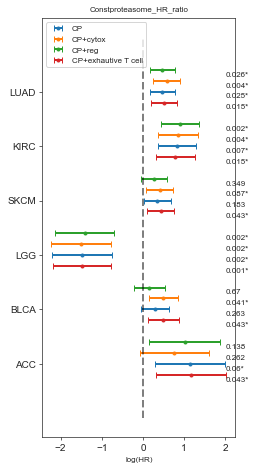

In [13]:
## plotting the signifcant hazard ratio in different tumor tissues.
tt_list=['ACC','BLCA','LGG','SKCM','KIRC','LUAD']

df_tmp_const=hazard_ratio_frame[0]
df_tmp_const=df_tmp_const.sort_values(by=['coef'])
df_tmp_const=df_tmp_const.loc[tt_list]
df_tmp_const['y_value']=np.array(range(1,7))

df_tmp_const_cytox=hazard_ratio_frame[2]
df_tmp_const_cytox=df_tmp_const_cytox.reindex(df_tmp_const.index)
df_tmp_const_cytox=df_tmp_const_cytox.loc[tt_list]
df_tmp_const_cytox['y_value']=np.array(range(1,7))

df_tmp_const_reg=hazard_ratio_frame[1]
df_tmp_const_reg=df_tmp_const_reg.reindex(df_tmp_const.index)
df_tmp_const_reg=df_tmp_const_reg.loc[tt_list]
df_tmp_const_reg['y_value']=np.array(range(1,7))

df_tmp_const_Exhausted_T_cell_score=hazard_ratio_frame[3]
df_tmp_const_Exhausted_T_cell_score=df_tmp_const_Exhausted_T_cell_score.reindex(df_tmp_const.index)
df_tmp_const_Exhausted_T_cell_score=df_tmp_const_Exhausted_T_cell_score.loc[tt_list]
df_tmp_const_Exhausted_T_cell_score['y_value']=np.array(range(1,7))


x = np.array(df_tmp_const['coef'])
y = np.array(df_tmp_const['y_value'])
err=np.array(df_tmp_const['error_bar'])
y_ticks_labels = list(df_tmp_const.index)
l1 = np.arange(1,7,1)

x_1 = np.array(df_tmp_const_cytox['coef'])
y_1 = np.array(df_tmp_const_cytox['y_value'])
y_1=y_1+0.20
err_1=np.array(df_tmp_const_cytox['error_bar'])
y_ticks_labels_1 = list(df_tmp_const_cytox.index)
l1_1 = np.arange(1,7,1)

x_2 = np.array(df_tmp_const_reg['coef'])
y_2 = np.array(df_tmp_const_reg['y_value'])
y_2=y_2+0.40
err_2=np.array(df_tmp_const_reg['error_bar'])
y_ticks_labels_2 = list(df_tmp_const_reg.index)
l1_2 = np.arange(1,7,1)

x_3 = np.array(df_tmp_const_Exhausted_T_cell_score['coef'])
y_3 = np.array(df_tmp_const_Exhausted_T_cell_score['y_value'])
y_3=y_3-0.20
err_3=np.array(df_tmp_const_Exhausted_T_cell_score['error_bar'])
y_ticks_labels_3 = list(df_tmp_const_Exhausted_T_cell_score.index)
l1_3 = np.arange(1,7,1)

sns.set_style("ticks")
fig, (ax1) = plt.subplots(1,1,figsize=(4, 7))

ax1.errorbar(x, y, xerr=err, fmt='.',elinewidth=2,solid_capstyle='projecting', capsize=3,label='CP') ## immuno
ax1.legend(loc='upper left')
df_tmp_const_1=df_tmp_const
df_tmp_const_1.loc[df_tmp_const_1['p_adjust']<0.1,'significance_value']='*'
df_tmp_const_1.loc[df_tmp_const_1['p_adjust']>0.1,'significance_value']=''
for i in range(6):
    ax1.annotate(str(round(df_tmp_const_1['p_adjust'][i],3))+df_tmp_const_1['significance_value'][i],xy=(2,y[i]-0.118),fontsize=8)
    
ax1.errorbar(x_1, y_1, xerr=err_1, fmt='.',elinewidth=2,solid_capstyle='projecting', capsize=3,label='CP+cytox') ## immuno adjusted for cytox
ax1.legend(loc='upper left')
df_tmp_const_1=df_tmp_const_cytox
df_tmp_const_1.loc[df_tmp_const_1['p_adjust']<0.1,'significance_value']='*'
df_tmp_const_1.loc[df_tmp_const_1['p_adjust']>0.1,'significance_value']=''
for i in range(6):
    ax1.annotate(str(round(df_tmp_const_1['p_adjust'][i],3))+df_tmp_const_1['significance_value'][i],xy=(2,y_1[i]-0.118),fontsize=8)

ax1.errorbar(x_2, y_2, xerr=err_2, fmt='.',elinewidth=2,solid_capstyle='projecting', capsize=3,label='CP+reg') ## immuno adjusted for regulatory
ax1.legend(loc='upper left')
df_tmp_const_1=df_tmp_const_reg
df_tmp_const_1.loc[df_tmp_const_1['p_adjust']<0.1,'significance_value']='*'
df_tmp_const_1.loc[df_tmp_const_1['p_adjust']>0.1,'significance_value']=''
for i in range(6):
    ax1.annotate(str(round(df_tmp_const_1['p_adjust'][i],3))+df_tmp_const_1['significance_value'][i],xy=(2,y_2[i]-0.118),fontsize=8)


ax1.errorbar(x_3, y_3, xerr=err_3, fmt='.',elinewidth=2,solid_capstyle='projecting', capsize=3,label='CP+exhautive T cell') ## Immuno adjusted for Exhaustive T cell
ax1.legend(loc='upper left')
df_tmp_const_1=df_tmp_const_Exhausted_T_cell_score
df_tmp_const_1.loc[df_tmp_const_1['p_adjust']<0.1,'significance_value']='*'
df_tmp_const_1.loc[df_tmp_const_1['p_adjust']>0.1,'significance_value']=''
for i in range(6):
    ax1.annotate(str(round(df_tmp_const_1['p_adjust'][i],3))+df_tmp_const_1['significance_value'][i],xy=(2,y_3[i]-0.118),fontsize=8)

ax1.plot([0, 0], [0, 7], color = 'black', linewidth = 2.0,alpha=0.5,linestyle="dashed")
ax1.set_yticks(l1)
ax1.set_yticklabels(y_ticks_labels, rotation='horizontal',fontsize=10)
ax1.set_title('Constproteasome_HR_ratio')
ax1.set_xlabel('log(HR)')
plt.xticks(fontsize=10)
fig.tight_layout(pad=3.0)
ax1.grid(False)
#plt.savefig("plots/"+'Cox_proportional_hazard_ratio_immune_cytox_reg_exhaustive_score_all_combined_CP'+'.svg',bbox_inches = "tight",dpi=500)
plt.show()